In [63]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage.measure import compare_ssim as ssim
import random
import time
from models.models import ConvLSTM, PhyCell, EncoderRNN
from data.moving_mnist import MovingMNIST
from constrain_moments import K2M
import argparse
from pathlib import Path

In [64]:
device = torch.cuda.current_device()

In [65]:
from fastai.vision.all import show_images

In [66]:
batch_size=64
n_frames = 5

In [67]:
path = Path.cwd()/'data'

In [68]:
mm = MovingMNIST(root=path, is_train=True, n_frames_input=n_frames, n_frames_output=n_frames, num_objects=[2])
train_loader = torch.utils.data.DataLoader(dataset=mm, batch_size=batch_size, shuffle=True, num_workers=8)

In [69]:
tmm = MovingMNIST(root=path, is_train=False, n_frames_input=n_frames, n_frames_output=n_frames, num_objects=[2])
test_loader  = torch.utils.data.DataLoader(dataset=tmm, batch_size=1, shuffle=False, num_workers=8)

some fastai magic

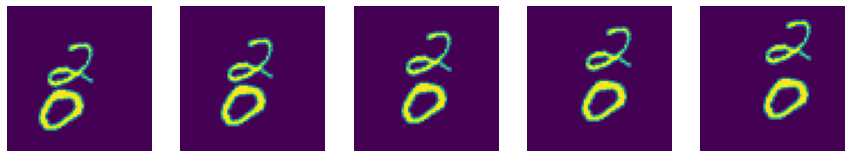

In [70]:
show_images(mm[4][1])

In [71]:
constraints = torch.zeros((49,7,7)).to(device)
ind = 0
for i in range(0,7):
    for j in range(0,7):
        constraints[ind,i,j] = 1
        ind +=1    

In [72]:
def train_on_batch(input_tensor, target_tensor, encoder, encoder_optimizer, criterion,teacher_forcing_ratio):                
    encoder_optimizer.zero_grad()
    # input_tensor : torch.Size([batch_size, input_length, 1, 64, 64])
    input_length  = input_tensor.size(1)
    target_length = target_tensor.size(1)
    loss = 0
    for ei in range(input_length-1): 
        encoder_output, encoder_hidden, output_image,_,_ = encoder(input_tensor[:,ei,:,:,:], (ei==0) )
        loss += criterion(output_image,input_tensor[:,ei+1,:,:,:])

    decoder_input = input_tensor[:,-1,:,:,:] # first decoder input = last image of input sequence
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False 
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
            target = target_tensor[:,di,:,:,:]
            loss += criterion(output_image,target)
            decoder_input = target 
         
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
            decoder_input = output_image
            target = target_tensor[:,di,:,:,:]
            loss += criterion(output_image, target)
 
    # Moment Regularisation  encoder.phycell.cell_list[0].F.conv1.weight # size (nb_filters,in_channels,7,7)
    k2m = K2M([7,7]).to(device)
    for b in range(0,encoder.phycell.cell_list[0].input_dim):
        filters = encoder.phycell.cell_list[0].F.conv1.weight[:,b,:,:] # (nb_filters,7,7)
        
        m = k2m(filters.double()) 
        m  = m.float()   
        loss += criterion(m, constraints) # constrains is a precomputed matrix   
    loss.backward()
    encoder_optimizer.step()
    return loss.item() / target_length

In [73]:
from fastprogress import progress_bar, master_bar

In [74]:
def trainIters(encoder, n_epochs, print_every,eval_every):
    start = time.time()
    train_losses = []
    best_mse = float('inf')

    encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=0.0001)
    scheduler_enc = ReduceLROnPlateau(encoder_optimizer, mode='min', patience=3,factor=0.5,verbose=True)
    criterion = nn.MSELoss()
    
    mb = master_bar(range(0, n_epochs ))
    for epoch in mb:
        t0 = time.time()
        loss_epoch = 0
        teacher_forcing_ratio = np.maximum(0 , 1 - epoch * 0.01)
        
        for i, out in progress_bar(list(enumerate(train_loader, 0)), parent=mb):
            #input_batch =  torch.Size([8, 20, 1, 64, 64])
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)
            loss = train_on_batch(input_tensor, target_tensor, encoder, encoder_optimizer, criterion, teacher_forcing_ratio)                                   
            loss_epoch += loss
            
        if (i%10)==0 :
            print(i, '/', len(train_loader) , ' loss= ' , loss)
            
        train_losses.append(loss_epoch)        
        if (epoch+1) % print_every == 0:
            print('epoch ',epoch,  ' loss ',loss_epoch , ' epoch time ',time.time()-t0)
            
        if (epoch+1) % eval_every == 0:
            mse, mae,ssim = evaluate(encoder,test_loader) 
            scheduler_enc.step(mse)                              
    return train_losses

In [75]:
def evaluate(encoder,loader):
    total_mse, total_mae,total_ssim,total_bce = 0,0,0,0
    with torch.no_grad():
        for i, out in progress_bar(enumerate(loader, 0)):
            #input_batch = torch.Size([8, 20, 1, 64, 64])
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)

            input_length = input_tensor.size()[1]
            target_length = target_tensor.size()[1]

            for ei in range(input_length-1):
                encoder_output, encoder_hidden, _,_,_  = encoder(input_tensor[:,ei,:,:,:], (ei==0))

            decoder_input = input_tensor[:,-1,:,:,:] # first decoder input= last image of input sequence
            predictions = []

            for di in range(target_length):
                decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input, False, False)
                decoder_input = output_image
                predictions.append(output_image.cpu())

            input = input_tensor.cpu().numpy()
            target = target_tensor.cpu().numpy()
            predictions =  np.stack(predictions) # for MM: (10, batch_size, 1, 64, 64)
            predictions = predictions.swapaxes(0,1)  # (batch_size,10, 1, 64, 64)

            mse_batch = np.mean((predictions-target)**2 , axis=(0,1,2)).sum()
            mae_batch = np.mean(np.abs(predictions-target) ,  axis=(0,1,2)).sum() 
            total_mse += mse_batch
            total_mae += mae_batch
            
            for a in range(0,target.shape[0]):
                for b in range(0,target.shape[1]):
                    total_ssim += ssim(target[a,b,0,], predictions[a,b,0,]) / (target.shape[0]*target.shape[1]) 
            
            cross_entropy = -target*np.log(predictions) - (1-target) * np.log(1-predictions)
            cross_entropy = cross_entropy.sum()
            cross_entropy = cross_entropy / (args.batch_size*target_length)
            total_bce +=  cross_entropy
     
    print('eval mse ', total_mse/len(loader),  ' eval mae ', total_mae/len(loader),' eval ssim ',total_ssim/len(loader), ' eval bce ', total_bce/len(loader))        
    return total_mse/len(loader),  total_mae/len(loader), total_ssim/len(loader)

# Actual Training

In [76]:
n_epochs = 10
print_every = 1
eval_every = 1 

In [77]:
print('BEGIN TRAIN')
phycell =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convlstm =  ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3), device=device)   
encoder = EncoderRNN(phycell, convlstm, device)

BEGIN TRAIN
layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


In [78]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
   
print('phycell ' , count_parameters(phycell) )    
print('convlstm ' , count_parameters(convlstm) ) 
print('encoder ' , count_parameters(encoder) ) 

phycell  230833
convlstm  2508032
encoder  2951002


In [ ]:
plot_losses = trainIters(encoder,n_epochs,print_every=print_every, eval_every=eval_every)
print(plot_losses)